Занятие 9. Логистическая регрессия
==================

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Хотим попробовать применить ту же модель линейной регрессии, но для задачи классификации. То есть
$$\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik} = y_i,$$
где $X_i = (x_{i1}, \ldots, x_{ik})$ -- строка с данными, $y_i\in\{0, 1\}$, $\beta_0, \ldots, \beta_k$ -- неизвестные коэффициенты.
Проблема в том, что слева стоит непрерывная функция по $x$, а справа -- дискретная переменная. Кроме того, при больших значениях $x$ функция слева будет гарантированно давать большие значения. Так что применить модель прямо в таком виде -- плохая идея.

Введём логистическую функцию (сигмоид) $\sigma(x)=\frac{1}{1+e^{-x}}$.

Text(0.5,1,'Логистическая функция')

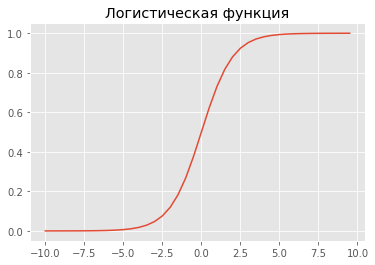

In [3]:
x = np.array(np.arange(-10, 10, 0.5))
y = 1. / (1 + np.exp(-x))
plt.plot(x, y)
plt.title(u'Логистическая функция')

Заметим, что $\sigma: \mathbb{R}\rightarrow (0, 1)$.

Применим к левой части логистическую функцию и будем решать задачу в виде
$$\sigma\left(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik}\right) = y_i.$$

Теперь слева у нас всегда будут получаться значения из $(0, 1)$, и это можно интерпретировать как вероятности принадлежности классу: если меньше 0.5, то класс 0, иначе -- класс 1.

Но теперь у нас пропадает аналитическое решение, которое было для линейной регрессии. Теперь придётся решать задачу оптимизации. Градиентный спуск (или другие методы) в помощь!

### Пример. Предсказание депозита. 

https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [4]:
df = pd.read_csv('bank-full.csv', sep=';')

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df = df.dropna()

Кроме обычных, пропущенные пропущенные значения числятся как 'unknown'. Посмотрим, как они распределены по колонкам.

In [7]:
df.apply(lambda x: sum(x == 'unknown'), axis=0)

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

Выбросим колонки ```contact```, ```poutcome```, ```duration``` полностью, и выбросим строчки с пропущенными значениями в колонках ```job``` и ```education```.

In [8]:
#df = df.drop(['contact', 'poutcome', 'duration'], axis=1)
#df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]
#df.shape


In [9]:
df = df.drop(['contact', 'poutcome'], axis=1)
df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]
df.shape


(43193, 15)

Заметим, что колонка ```education``` имеет естественный порядок, а колонки ```default```, ```housing``` и ```loan``` -- бинарные. Преобразуем их в численные. Колонку ```y``` тоже, само собой.

In [10]:
print (df['education'].value_counts())
print (df['default'].value_counts())
print (df['housing'].value_counts())
print (df['loan'].value_counts())
print (df['y'].value_counts())

secondary    23131
tertiary     13262
primary       6800
Name: education, dtype: int64
no     42411
yes      782
Name: default, dtype: int64
yes    24292
no     18901
Name: housing, dtype: int64
no     36086
yes     7107
Name: loan, dtype: int64
no     38172
yes     5021
Name: y, dtype: int64


In [11]:
df['education'] = df['education'].map({'primary': 0, 'secondary': 1, 'tertiary': 2})
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['y'] = df['y'].map({'no': 0, 'yes': 1})

Категориальные колонки ```job```, ```marital```, ```month``` не имеют естественного порядка, поэтому преобразуем их с помощью one-hot encoding.

In [12]:
cat_features = ['job', 'marital', 'month']
df = pd.get_dummies(df, columns=cat_features)

Выбросим колонку-отклик и соберём все данные в матрицу X.

In [13]:
X = df.drop('y', axis=1)
y = df['y']

In [14]:
X.shape

(43193, 37)

Логистическая модель в sklearn реализована в классе ```LogisticRegression``` библиотеки ```linear_model```.

In [15]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    # метод для поиска решения. Для небольших датасетов лучше подходит liblinear, sag и saga -- для больших.
    # Варианты: newton-cg, lbfgs, liblinear, sag, saga
    solver='liblinear',
    # норма для регуляризации. Варианты: l2, l1.
    penalty='l2',
    # параметр регуляризации. Чем меньше, тем сильнее регуляризация. Положительный.
    C=1,
    # параметр для остановки поиска решения.
    tol=1e-4,
    # Так как распознается 2 класса.
    multi_class='ovr'
    )

In [16]:
model.fit(X, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
preds = model.predict(X)

In [20]:
preds

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [22]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y, preds)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,37293,879
1,3666,1355


In [23]:
pred_prob = model.predict_proba(X)

In [26]:
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)


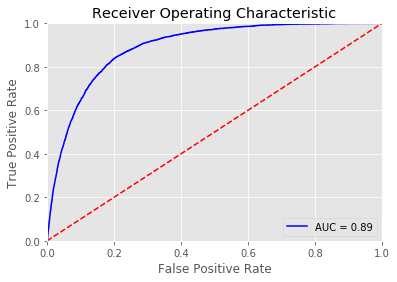

In [27]:


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [ ]:
# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

In [62]:
zzz = pd.DataFrame(rfe.predict(X))

#  zzz.head()

zzz.shape()

TypeError: 'tuple' object is not callable

Метод главных компонент
=============

https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease

In [201]:
df = pd.read_csv('kidney_disease.csv', index_col=0)
df = df.dropna()
labels = ['red' if i == 'ckd' else 'green' for i in df['classification']]
df = df[['bgr', 'wc', 'rc']]
df.head()

,bgr,wc,rc
id,,,
3,117.0,6700,3.9
9,70.0,12100,3.7
11,380.0,4500,3.8
14,157.0,11000,2.6
20,173.0,9200,3.2


In [209]:
import math
from sklearn import preprocessing
from sklearn.decomposition import PCA


def scale_features(df):
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    return scaled


def draw_vectors(transformed_features, components_, columns, plt, scaled):
    if not scaled:
        return plt.axes()

    num_columns = len(columns)
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print "Features by importance:\n", important_features

    ax = plt.axes()

    for i in range(num_columns):
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

[ 0.53693027  0.27122311  0.19184662]
Features by importance:
[(3.999807155688483, 'wc'), (3.258887664121087, 'bgr'), (3.009752752998363, 'rc')]


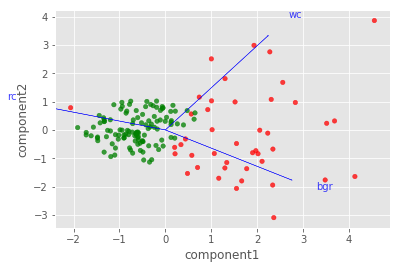

In [210]:
scaleFeatures = True

if scaleFeatures:
    df2 = scale_features(df)
else:
    df2 = df.copy()

pca = PCA(n_components=3)
pca.fit(df2)
print pca.explained_variance_ratio_
T = pca.transform(df2)[:, 0:2]

ax = draw_vectors(T, pca.components_, df2.columns.values, plt, scaleFeatures)
T = pd.DataFrame(T)
T.columns = ['component1', 'component2']
T.plot.scatter(x='component1', y='component2', marker='o', c=labels, alpha=0.75, ax=ax)

In [211]:
pca.components_

array([[ 0.60180443,  0.49016625, -0.63053032],
       [-0.45604187,  0.85904029,  0.23254161],
       [ 0.65563499,  0.14760365,  0.74051058]])